# Imports y Preprocesamiento de Datos


In [2]:
#Importamos librerías
#%reload_ext tgpy
import torch
import tgpy as tg
import matplotlib.pyplot as plt
import mpl_scatter_density
import utm
import pydeck as pdk
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.metrics import mean_absolute_error

In [3]:
#Configuración para los gráficos
sb.set_context('notebook', font_scale=1.4)
sb.set_style('ticks')
plt.rcParams['figure.figsize'] = (12, 5)

In [4]:
sunspotsMensual = pd.read_csv("Sunspots.csv")

sunspotsMensual["Year"] = pd.DatetimeIndex(sunspotsMensual['Date']).year
sunspotsMensual = sunspotsMensual.rename(columns={"Monthly Mean Total Sunspot Number":"Yearly Mean Total Sunspot Number"})
sunspotsMensual = sunspotsMensual.drop(["Unnamed: 0"], axis=1)

sunspotsAnual = sunspotsMensual.groupby("Year", as_index=False).mean()
sunspotsAnual

Year  Yearly Mean Total Sunspot Number
0    1749                        134.875000
1    1750                        139.000000
2    1751                         79.441667
3    1752                         79.666667
4    1753                         51.125000
..    ...                               ...
268  2017                         21.816667
269  2018                          7.008333
270  2019                          3.583333
271  2020                          8.625000
272  2021                         10.400000

[273 rows x 2 columns]

In [5]:
# random seed
np.random.seed(333)
t = sunspotsAnual['Year']
y = sunspotsAnual['Yearly Mean Total Sunspot Number']
prop = 0.5
nobs = int(prop*len(t))
perm = tg.np.random.permutation(sunspotsAnual.index)
train_index = np.sort(perm[:nobs])
valid_index = np.sort(perm[nobs:])
t_obs = t[train_index]
y_obs = y[train_index]

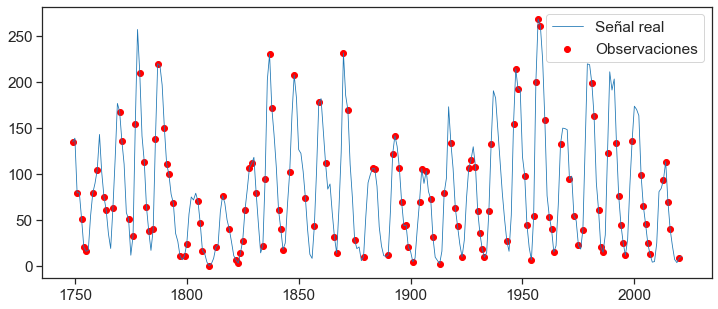

In [6]:
# Graficamos
plt.plot(t, y, label='Señal real', lw=0.8)
plt.scatter(t_obs, y_obs, c='r', label='Observaciones')
plt.legend()
plt.show()

0.0
268.84166666666664


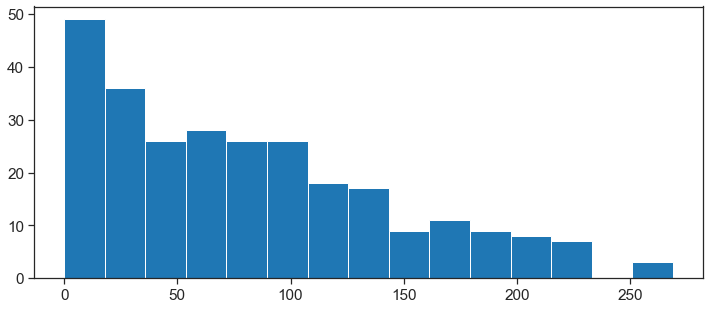

In [7]:
plt.hist(y,15)
print(min(y))
print(max(y))

## Análisis de Frecuencias

In [71]:
from scipy import signal

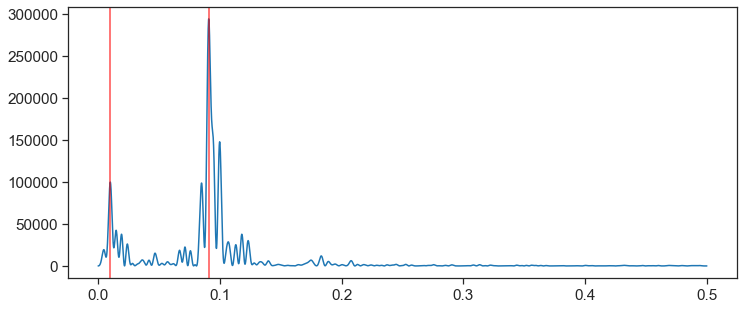

In [45]:
freqs, pxx = signal.periodogram(y, nfft=10000)

plt.plot(freqs, pxx)
plt.axvline(x=0.0909, c='r', alpha=0.7)
plt.axvline(x=0.01, c='r', alpha=0.7)

In [46]:
sorted(
    zip(freqs, pxx), 
    key=lambda x: x[1],
    reverse=True)

[(0.09090000000000001, 293884.24151894596),
 (0.0908, 293805.5262686704),
 (0.091, 292885.3330464553),
 (0.0907, 292608.12547411915),
 (0.0911, 290863.8789095014),
 (0.0906, 290265.8548445188),
 (0.0912, 287887.8636509476),
 (0.09050000000000001, 286768.00520258583),
 (0.0913, 284036.84036141436),
 (0.09040000000000001, 282119.6663830656),
 (0.09140000000000001, 279400.38948454795),
 (0.0903, 276341.77289973013),
 (0.0915, 274076.40347397997),
 (0.0902, 269470.8722899831),
 (0.0916, 268169.23003177677),
 (0.0917, 261787.70963402852),
 (0.0901, 261558.62241920637),
 (0.0918, 255043.14531244233),
 (0.09000000000000001, 252671.02920543644),
 (0.09190000000000001, 248047.24415797982),
 (0.08990000000000001, 242887.4411035097),
 (0.092, 240910.0707064476),
 (0.0921, 233738.05223640252),
 (0.0898, 232299.32116907803),
 (0.0922, 226632.07505433602),
 (0.0897, 221008.82151935776),
 (0.09230000000000001, 219685.70907628778),
 (0.09240000000000001, 212983.59547187804),
 (0.0896, 209127.188443502

In [1]:
T1 = 1/0.0909
print(T1)

11.001100110011002


## Función de Entrenamiento

In [8]:
def train(tgp, quantiles = 0.9, nsamples = 10, delta = 0.5, npoints = 21):
    tgp.sample_priors()
    tgp.plot_priors(kde=True)
    learning = tg.TgLearning(tgp, lr=0.001, pbatch=0.8, rand_pert=0.0, pot=0, cycle=0.1)
    learning.execute_sgd(100)
    tgp.plot_priors(kde=True)
    return 

# Non Statinary Kernels

## Modelo Kernel Lineal

In [9]:
def model(df, index_obs, dim = 100): 
    inputs = ['Year']
    outputs = ["Yearly Mean Total Sunspot Number"]
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)

    relevance = tg.TgPrior('relevance', ['Year'], dim=dim, low=0.0, high=0.5, alpha=2, beta=4) #low = 0.0, high = 2
    shift = tg.TgPrior('shift', ['Sunspots'], dim=dim, low=-0.01, high=0.01, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Sunspots'], dim=dim, low=0, high=1.2, alpha=2, beta=4)
    
    kernel = tg.LIN(relevance)
    cov = tg.CovarianceTransport(kernel)
    marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift) )
    positive = tg.MarginalTransport(tg.Relu())

    tgp = tg.TGP([cov, marginal, positive], dt=dt)
    tgp.obs(index_obs)
    return tgp

In [10]:
tgp = model(sunspotsAnual, train_index)

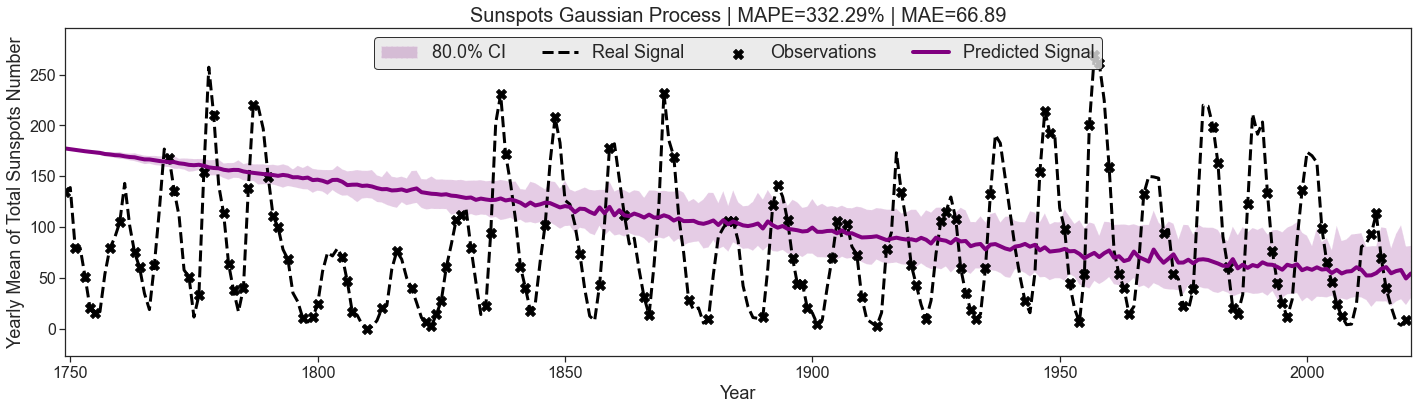

In [81]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number', nsamples = 10,  valid_index = valid_index,
                 pred_kwargs={'c':'purple', 'lw':4, 'label':'Predicted Signal', 'alpha':1.0},
                 CI_kwargs={'facecolor':'purple', 'alpha':0.2, 'ls':'--'})

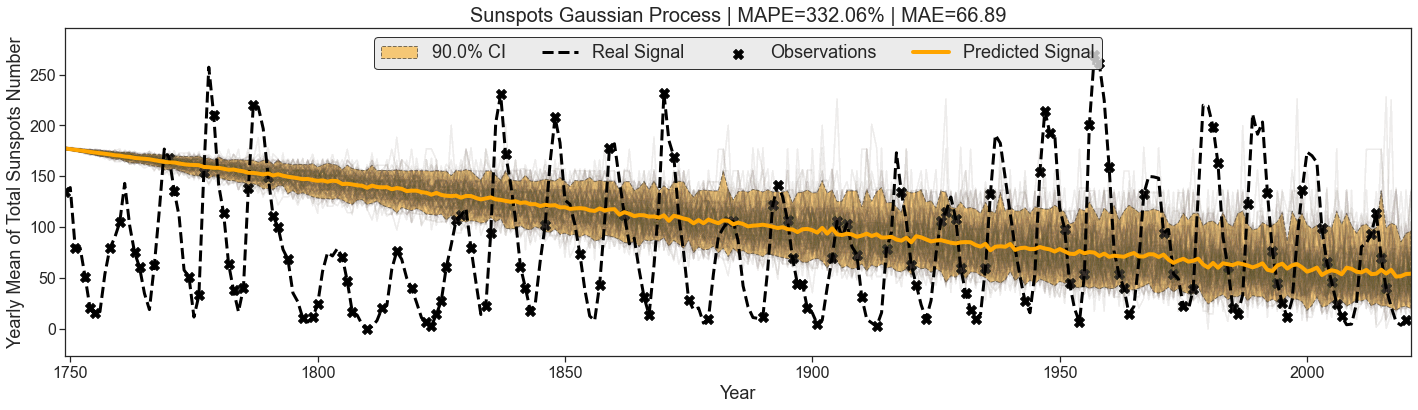

In [14]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number', 
                 nsamples = 10,  valid_index = valid_index, quantile = 0.05,
                 pred_kwargs={'c':'orange', 'lw':4, 'label':'Predicted Signal', 'alpha':1.0}, plot_samples = True,
                 CI_kwargs={'facecolor':'orange', 'alpha':0.5, 'ls':'--', 'edgecolor':'black'},
                 samples_kwargs={'alpha':0.01})

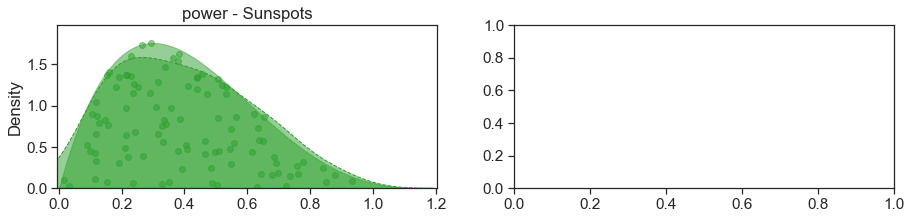

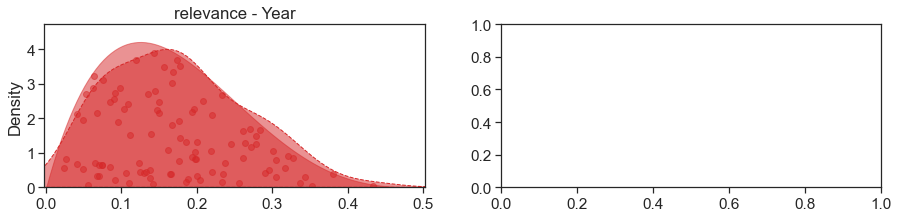

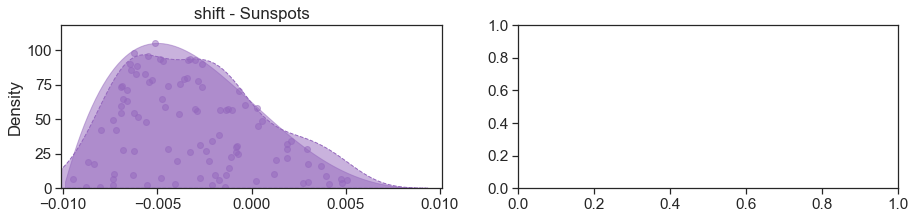

  0%|                                                                                                         …

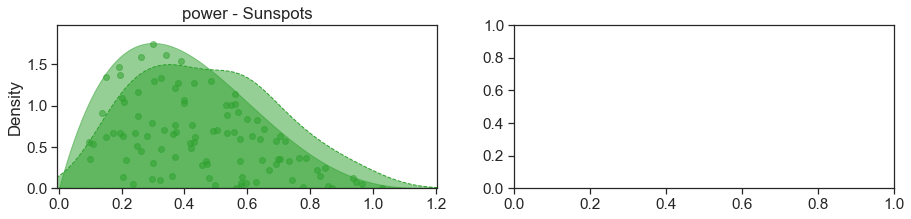

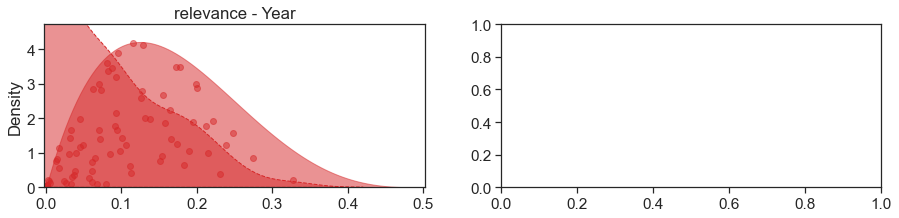

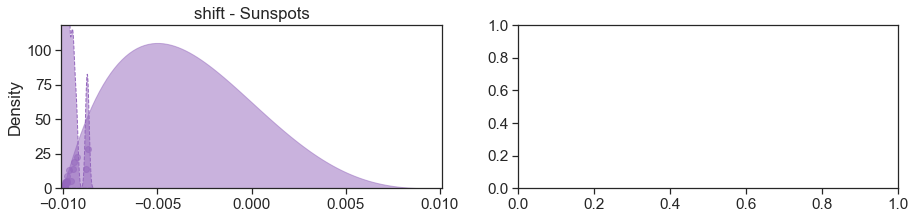

In [82]:
train(tgp)

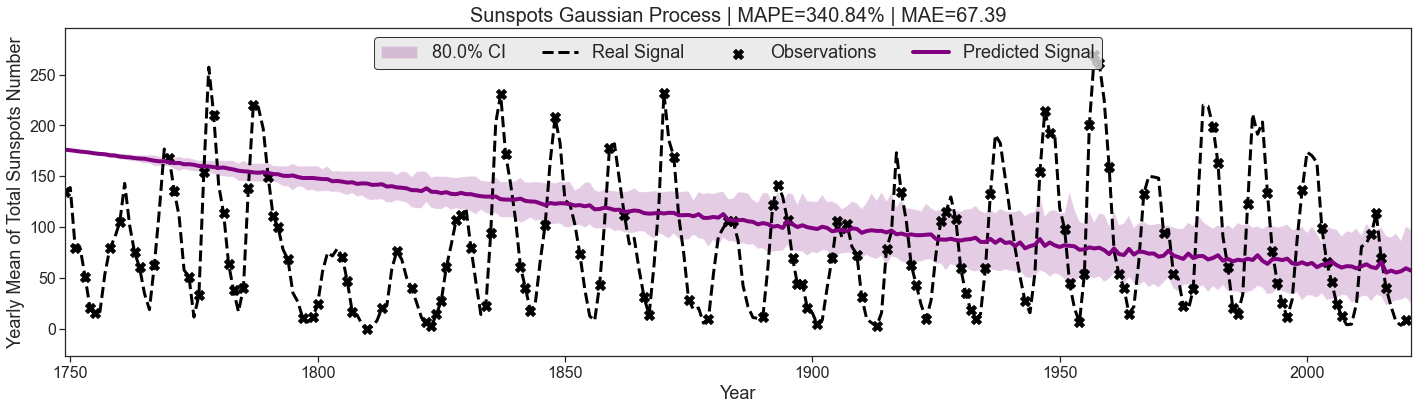

In [83]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number', nsamples = 10,  valid_index = valid_index,
                 pred_kwargs={'c':'purple', 'lw':4, 'label':'Predicted Signal', 'alpha':1.0},
                 CI_kwargs={'facecolor':'purple', 'alpha':0.2, 'ls':'--'})

## Modelo Kernel Polinomial

In [91]:
def model(df, index_obs, dim = 100): 
    inputs = ['Year']
    outputs = ["Yearly Mean Total Sunspot Number"]
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)

    relevance = tg.TgPrior('relevance', ['Year'], dim=dim, low=0.0, high=0.5, alpha=2, beta=4) #low = 0.0, high = 2
    shift = tg.TgPrior('shift', ['Sunspots'], dim=dim, low=-0.01, high=0.01, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Sunspots'], dim=dim, low=0, high=2, alpha=2, beta=4)
    power_marginal = tg.TgPrior('power', ['Sunspots'], dim=dim, low=0, high=1.2, alpha=2, beta=4)
    
    kernel = tg.POL(relevance, power)
    cov = tg.CovarianceTransport(kernel)
    marginal = tg.MarginalTransport(tg.BoxCoxShift(power_marginal, shift) )
    positive = tg.MarginalTransport(tg.Relu())
    
    tgp = tg.TGP([cov, marginal, positive], dt=dt)
    tgp.obs(index_obs)
    return tgp

In [92]:
tgp = model(sunspotsAnual, train_index)

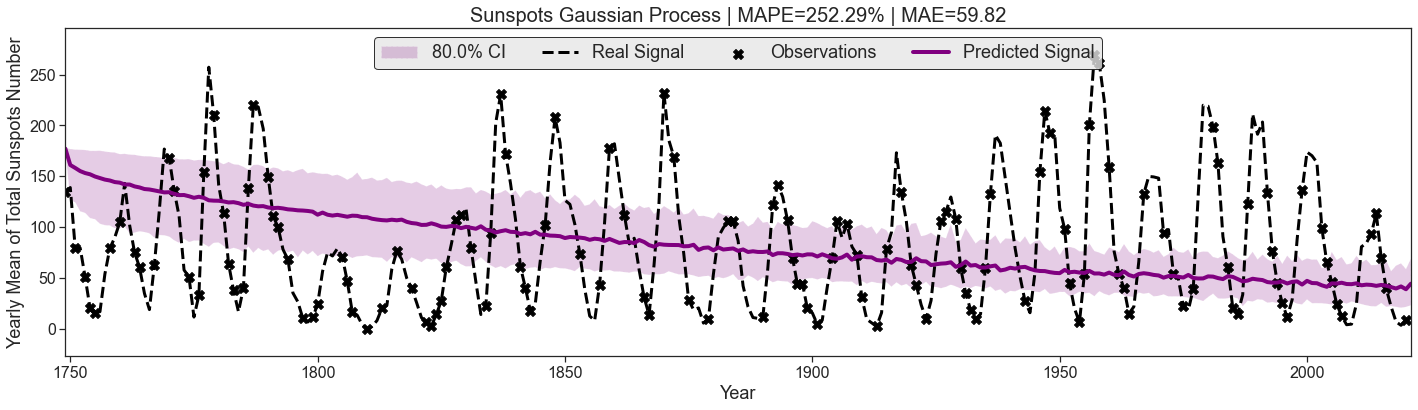

In [93]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number', nsamples = 10,  valid_index = valid_index,
                 pred_kwargs={'c':'purple', 'lw':4, 'label':'Predicted Signal', 'alpha':1.0},
                 CI_kwargs={'facecolor':'purple', 'alpha':0.2, 'ls':'--'})

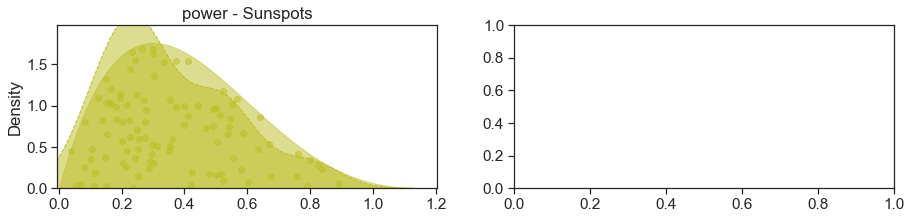

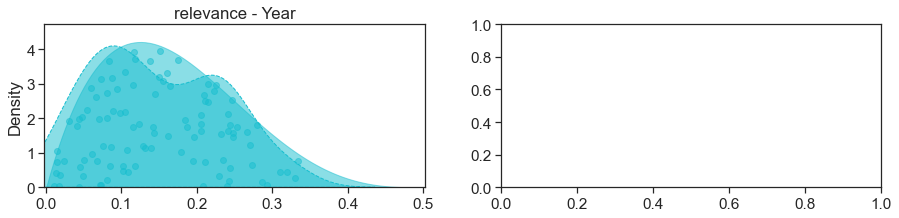

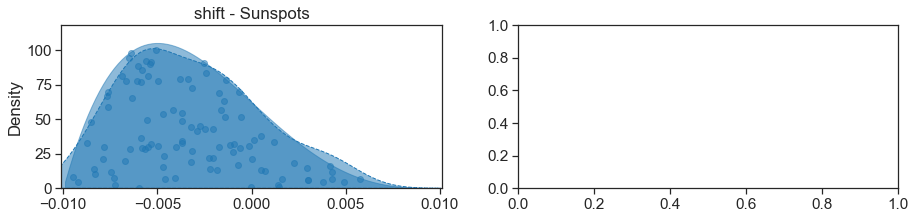

  0%|                                                                                                         …

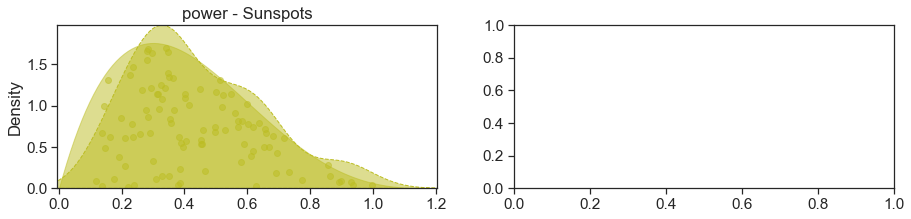

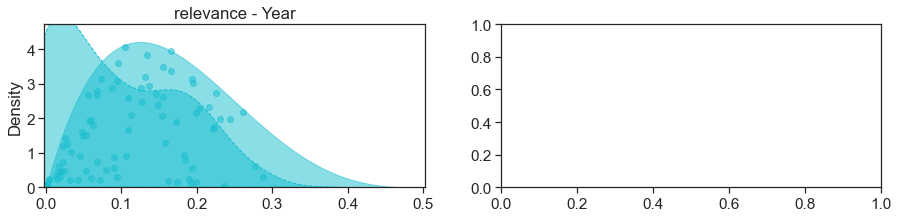

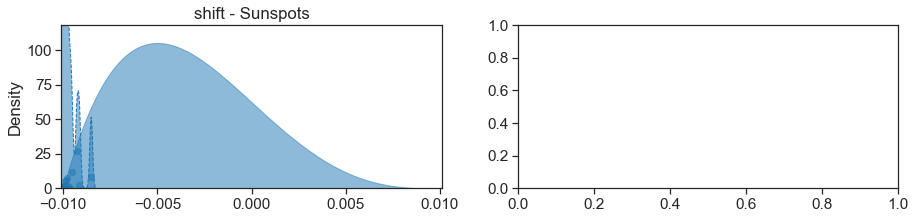

In [94]:
train(tgp)

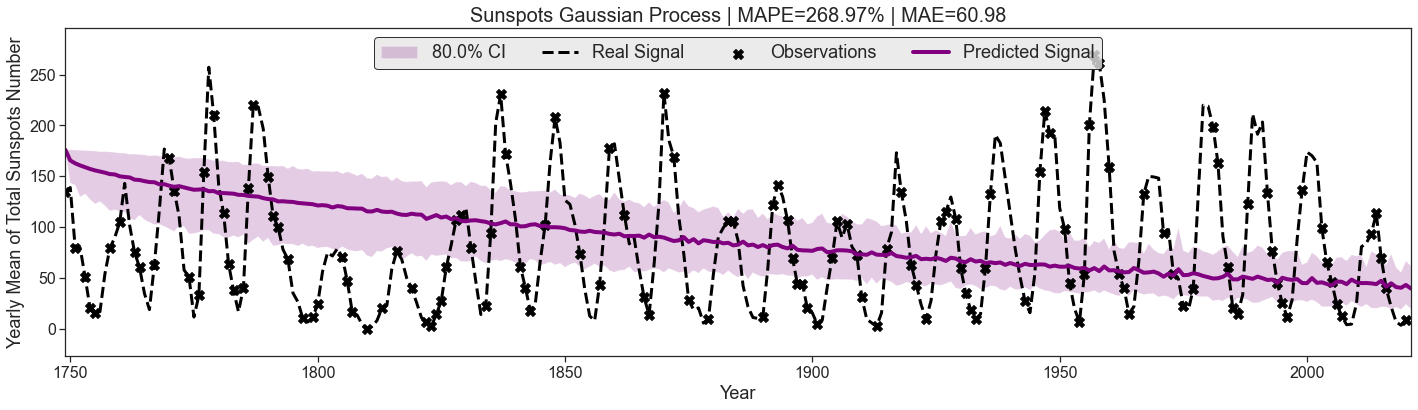

In [95]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number', nsamples = 10,  valid_index = valid_index,
                 pred_kwargs={'c':'purple', 'lw':4, 'label':'Predicted Signal', 'alpha':1.0},
                 CI_kwargs={'facecolor':'purple', 'alpha':0.2, 'ls':'--'})

# Stationary Kernels

## Modelo Kernel SE

In [29]:
def model(df, index_obs, dim = 100): 
    inputs = ['Year']
    outputs = ["Yearly Mean Total Sunspot Number"]
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)
    
    var_se = tg.TgPrior('var_rq', ['Sunspots'], dim=dim, low=0, high=1, alpha=2, beta=4)
    relevance = tg.TgPrior('relevance', ['Year'], dim=dim, low=0.0, high=0.5, alpha=2, beta=4) #low = 0.0, high = 2
    shift = tg.TgPrior('shift', ['Sunspots'], dim=dim, low=-0.01, high=0.01, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Sunspots'], dim=dim, low=0, high=1.2, alpha=2, beta=4)
    
    kernel = tg.SE(var_se, relevance)
    cov = tg.CovarianceTransport(kernel)
    marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift) )
    positive = tg.MarginalTransport(tg.Relu())
    
    tgp = tg.TGP([cov, marginal, positive], dt=dt)
    tgp.obs(index_obs)
    return tgp

### No entrenado

In [30]:
tgp = model(sunspotsAnual, train_index)

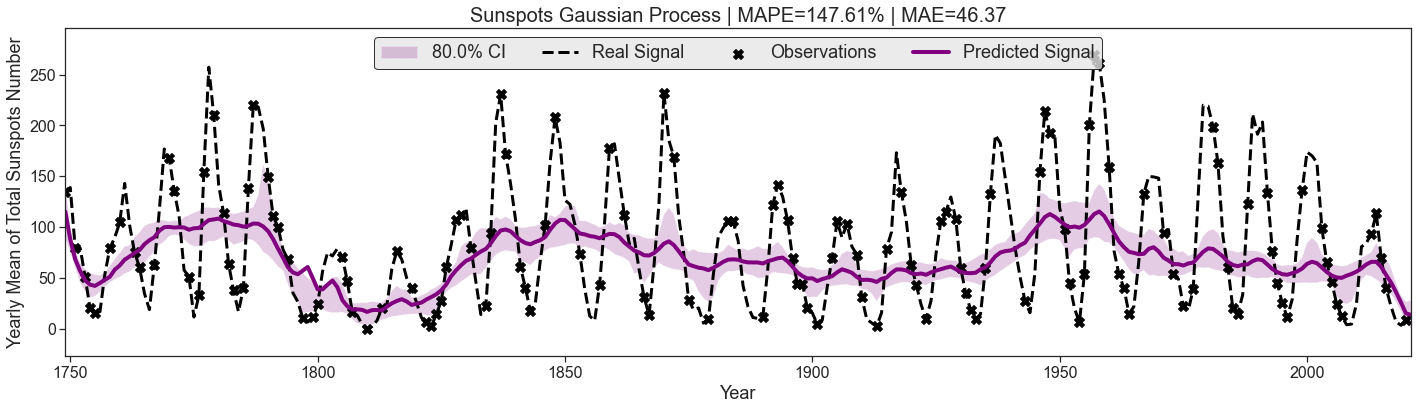

In [31]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number', 
                 nsamples = 10,  valid_index = valid_index, noise=True,
                 pred_kwargs={'c':'purple', 'lw':4, 'label':'Predicted Signal', 'alpha':1.0},
                 CI_kwargs={'facecolor':'purple', 'alpha':0.2, 'ls':'--'})

### Entrenado

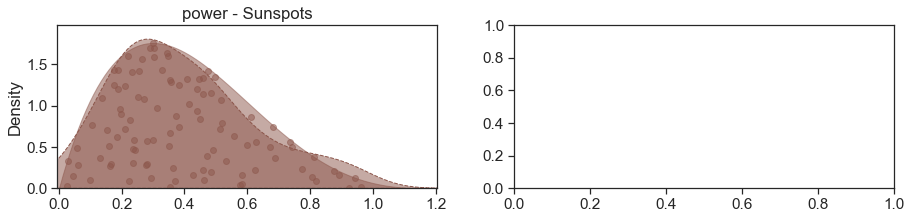

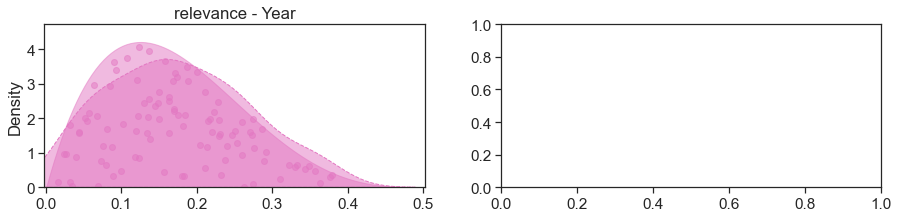

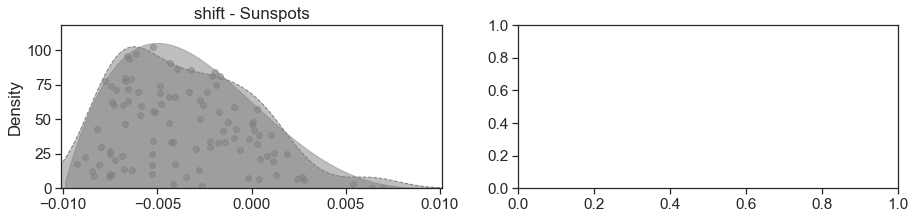

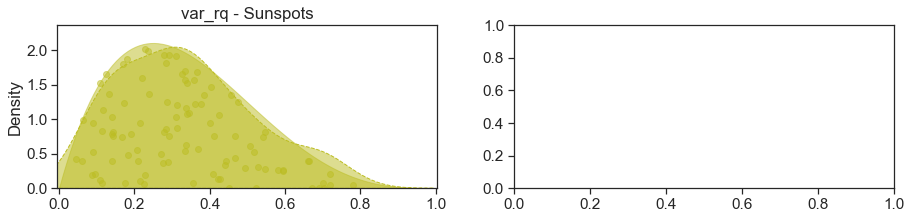

  0%|                                                                                                         …

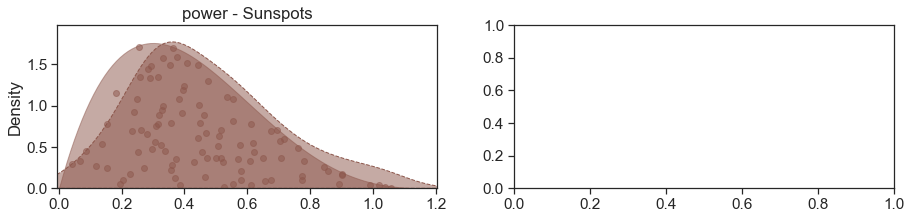

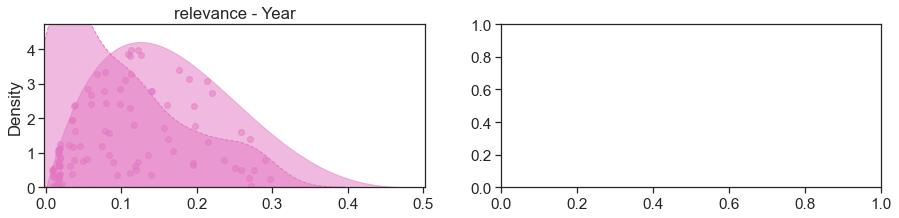

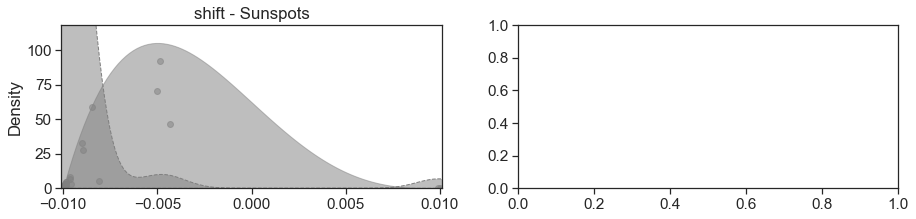

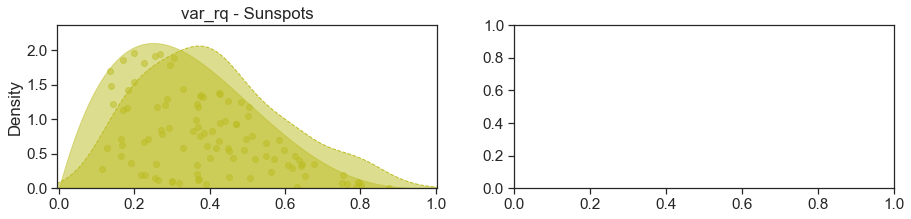

In [32]:
train(tgp)

### Gráfico

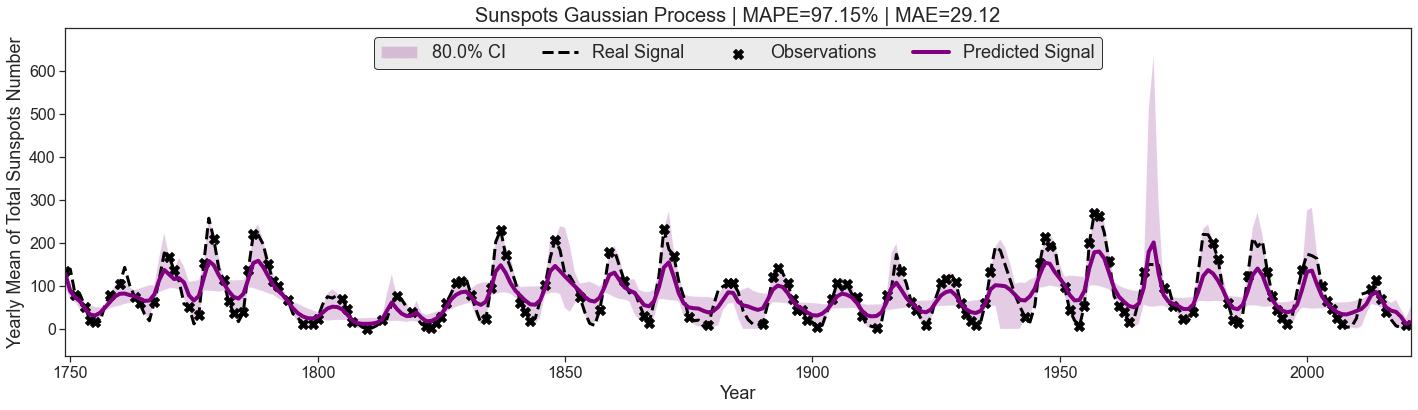

In [33]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number', 
                 nsamples = 10,  valid_index = valid_index, noise=True,
                 pred_kwargs={'c':'purple', 'lw':4, 'label':'Predicted Signal', 'alpha':1.0},
                 CI_kwargs={'facecolor':'purple', 'alpha':0.2, 'ls':'--'})

## Modelo Kernel RQ

In [116]:
def model(df, index_obs, dim = 100): 
    inputs = ['Year']
    outputs = ["Yearly Mean Total Sunspot Number"]
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)
    
    var_rq = tg.TgPrior('var_rq', ['Sunspots'], dim=dim, low=0, high=1, alpha=2, beta=4)
    relevance = tg.TgPrior('relevance', ['Year'], dim=dim, low=0.0, high=0.05, alpha=2, beta=4) #low = 0.0, high = 2
    freedom = tg.TgPrior('freedom', ['Sunspots'], dim=dim, low=1, high=5, alpha=2, beta=4) #low = 1, high = 5 
    shift = tg.TgPrior('shift', ['Sunspots'], dim=dim, low=-0.01, high=0.01, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Sunspots'], dim=dim, low=0, high=1.2, alpha=2, beta=4)
    
    kernel = tg.RQ(var_rq, relevance, freedom)
    cov = tg.CovarianceTransport(kernel)
    marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift) )
    positive = tg.MarginalTransport(tg.Relu())
    
    tgp = tg.TGP([cov, marginal, positive], dt=dt)
    tgp.obs(index_obs)
    return tgp

### No entrenado

In [118]:
tgp = model(sunspotsAnual, train_index)

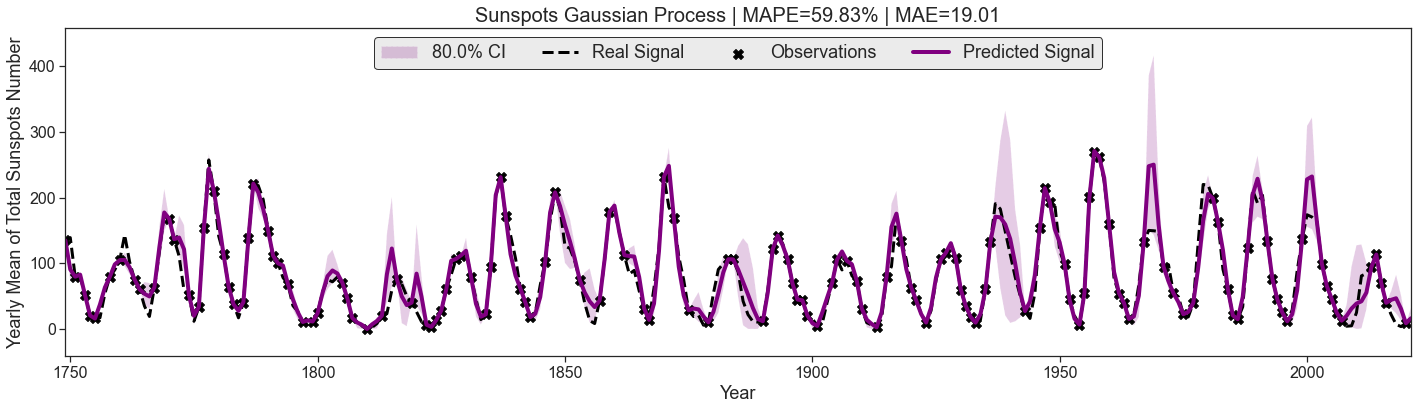

In [119]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number', 
                 nsamples = 10,  valid_index = valid_index, noise=True,
                 pred_kwargs={'c':'purple', 'lw':4, 'label':'Predicted Signal', 'alpha':1.0},
                 CI_kwargs={'facecolor':'purple', 'alpha':0.2, 'ls':'--'})

### Entrenado

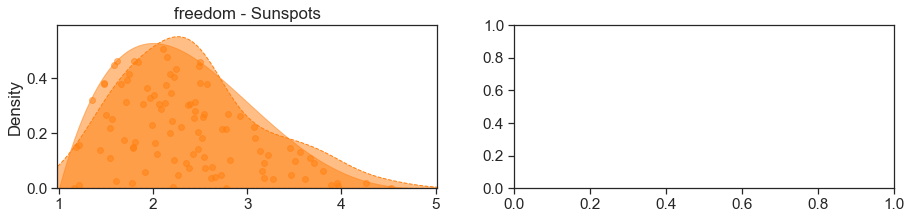

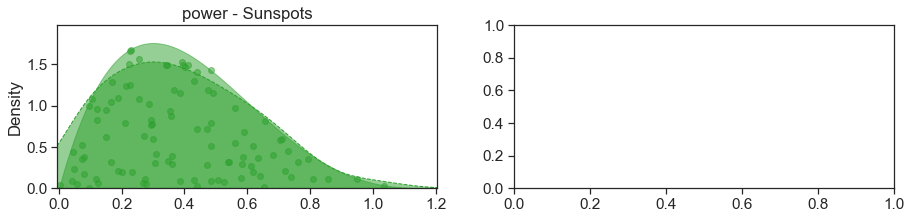

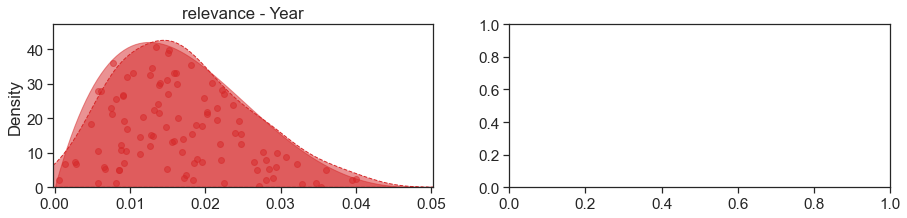

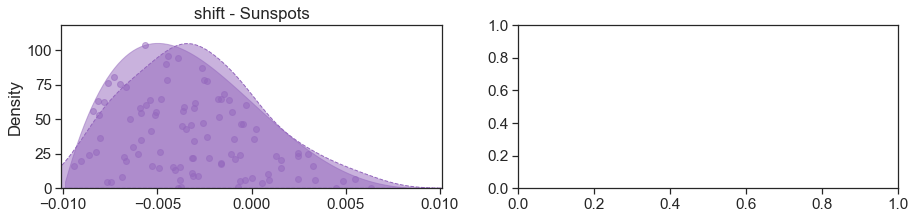

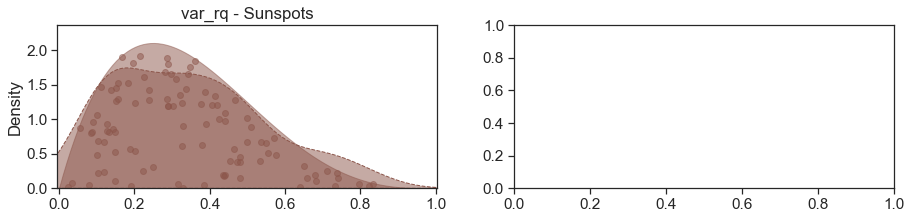

  0%|                                                                                                         …

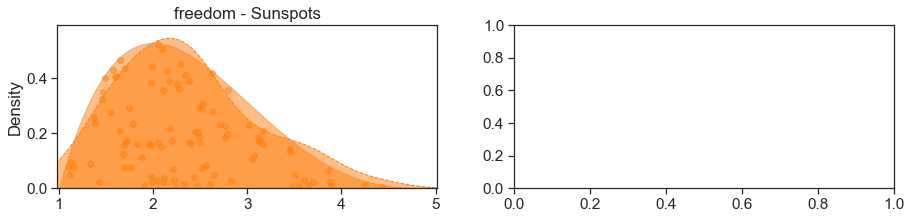

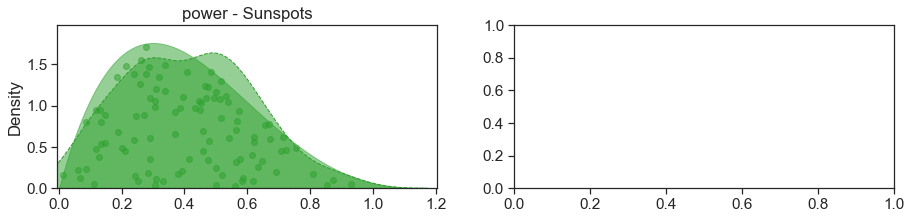

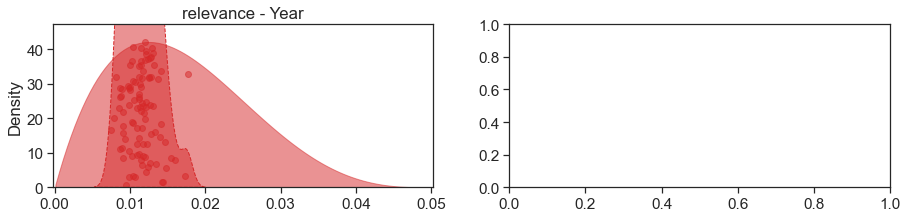

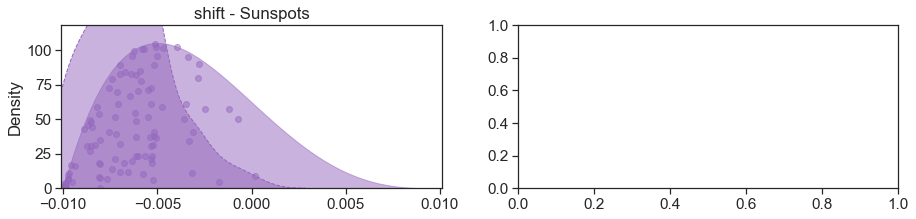

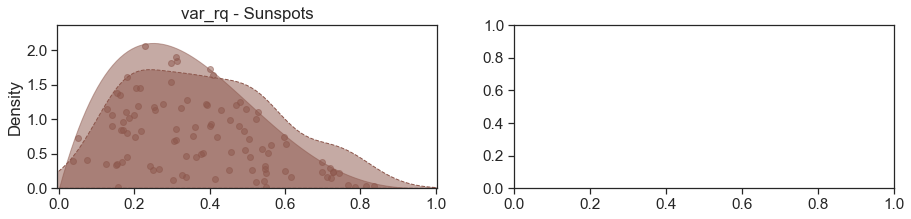

In [120]:
train(tgp)

### Gráfico

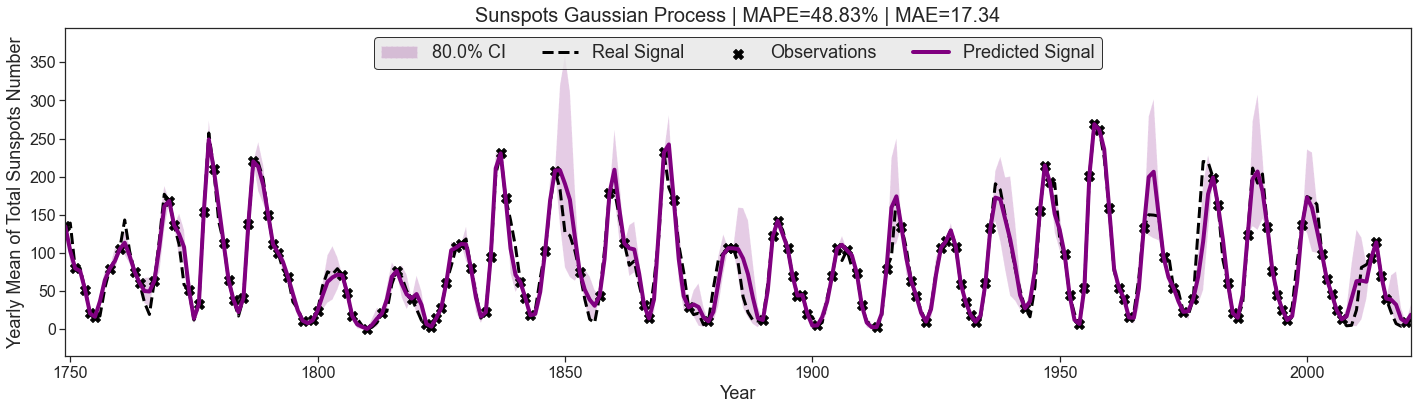

In [121]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number', 
                 nsamples = 10,  valid_index = valid_index, noise=True,
                 pred_kwargs={'c':'purple', 'lw':4, 'label':'Predicted Signal', 'alpha':1.0},
                 CI_kwargs={'facecolor':'purple', 'alpha':0.2, 'ls':'--'})

# Periodic Kernels

## Modelo Kernel SINC

In [156]:
def model(df, index_obs, dim = 100): 
    inputs = ['Year']
    outputs = ["Yearly Mean Total Sunspot Number"]
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)
    
    var_sinc = tg.TgPrior('var_rq', ['Year'], dim=dim, low=0, high=1, alpha=2, beta=4)
    relevance = tg.TgPrior('relevance', ['Year'], dim=dim, low=0.0, high=2, alpha=2, beta=4) #low = 0.0, high = 2
    period = tg.TgPrior('period', ['Year'], dim=dim, low=0.01, high=0.06, alpha=2, beta=4) #low = 1, high = 5 
    shift = tg.TgPrior('shift', ['Year'], dim=dim, low=-0.1, high=0.01, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Year'], dim=dim, low=0, high=1.2, alpha=2, beta=4)
    
    kernel = tg.SINC(var_sinc, relevance, period)
    cov = tg.CovarianceTransport(kernel)
    
    marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift) )
    positive = tg.MarginalTransport(tg.Relu())
    
    tgp = tg.TGP([cov, marginal, positive], dt=dt)
    tgp.obs(index_obs)
    return tgp

### No entrenado

In [157]:
tgp = model(sunspotsAnual, train_index)

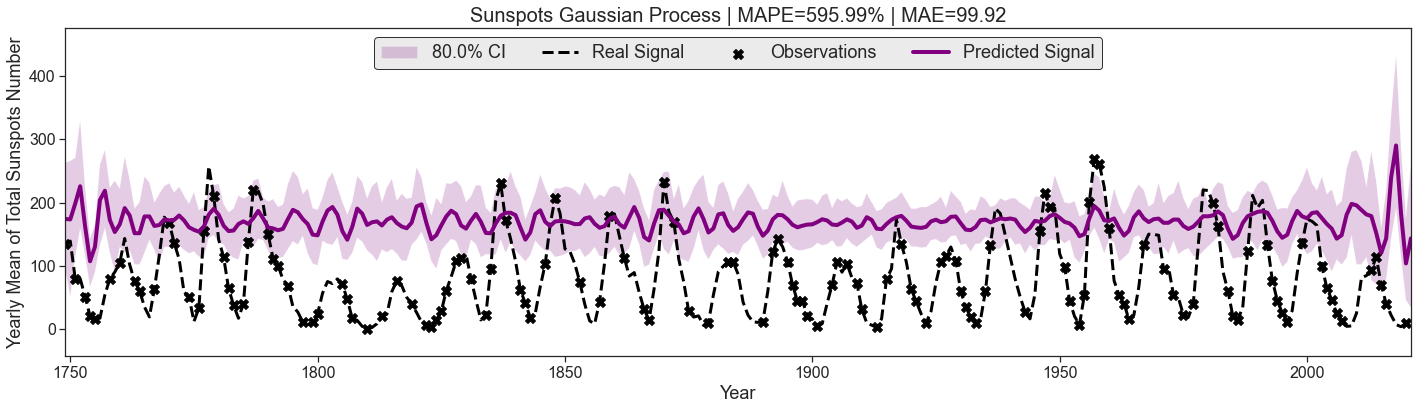

In [158]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number', 
                 nsamples = 10,  valid_index = valid_index, noise=True,
                 pred_kwargs={'c':'purple', 'lw':4, 'label':'Predicted Signal', 'alpha':1.0},
                 CI_kwargs={'facecolor':'purple', 'alpha':0.2, 'ls':'--'})

### Entrenado

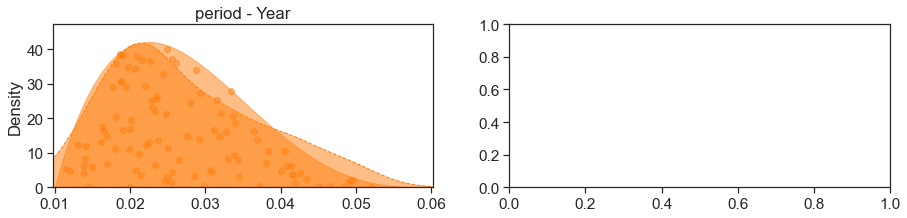

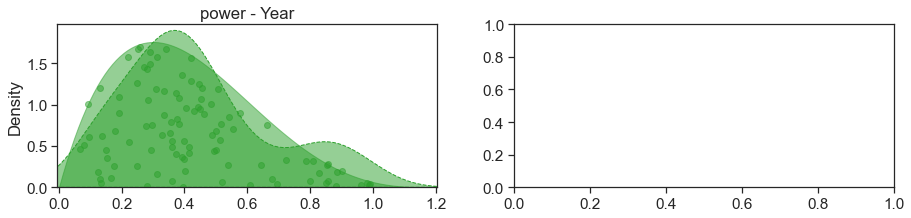

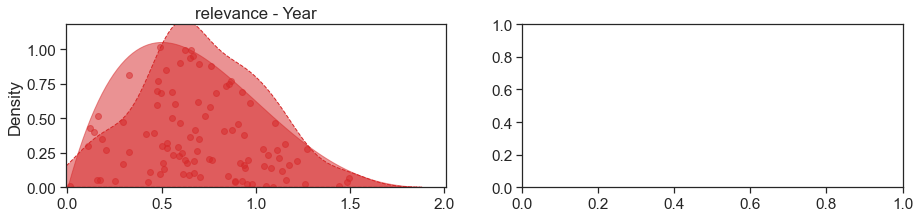

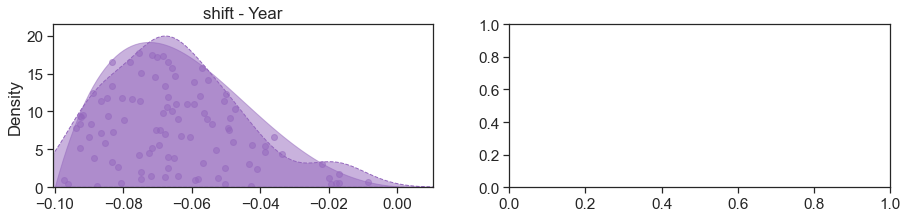

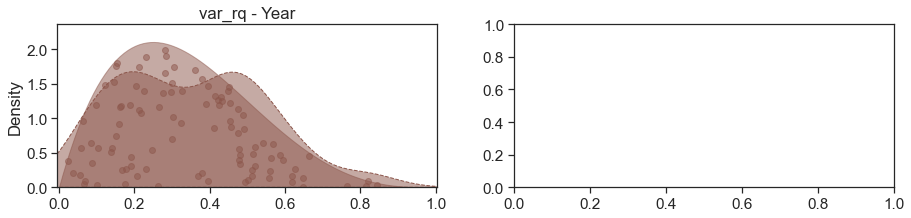

  0%|                                                                                                         …

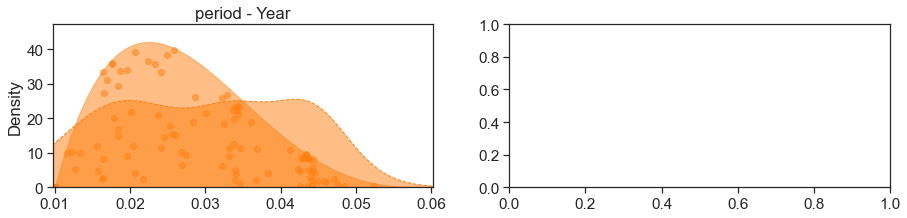

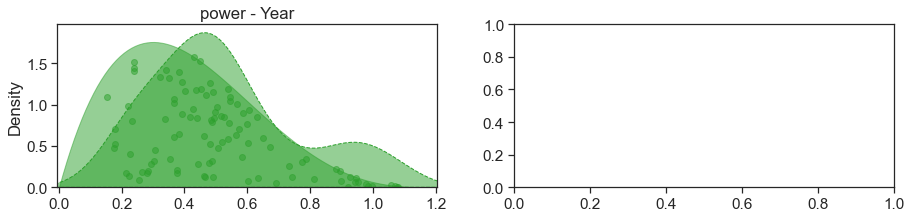

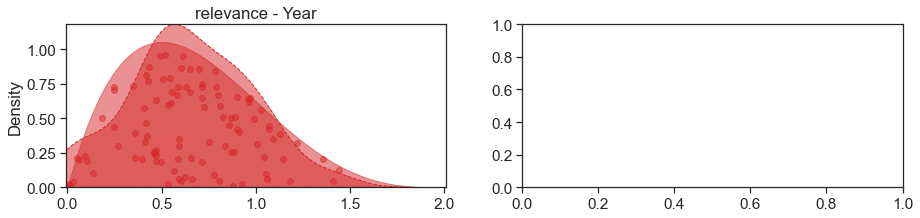

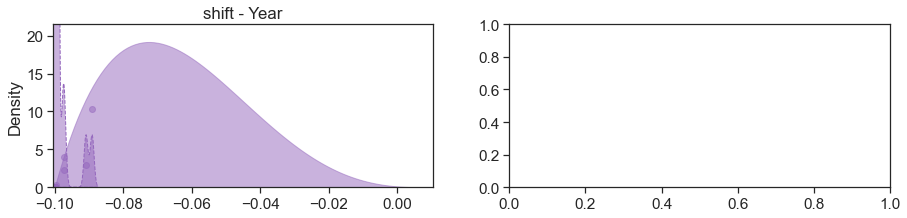

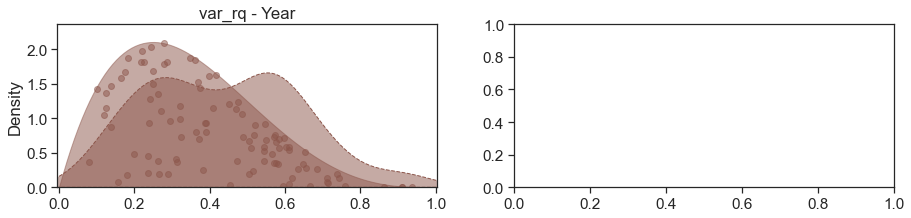

In [159]:
train(tgp)

### Gráfico

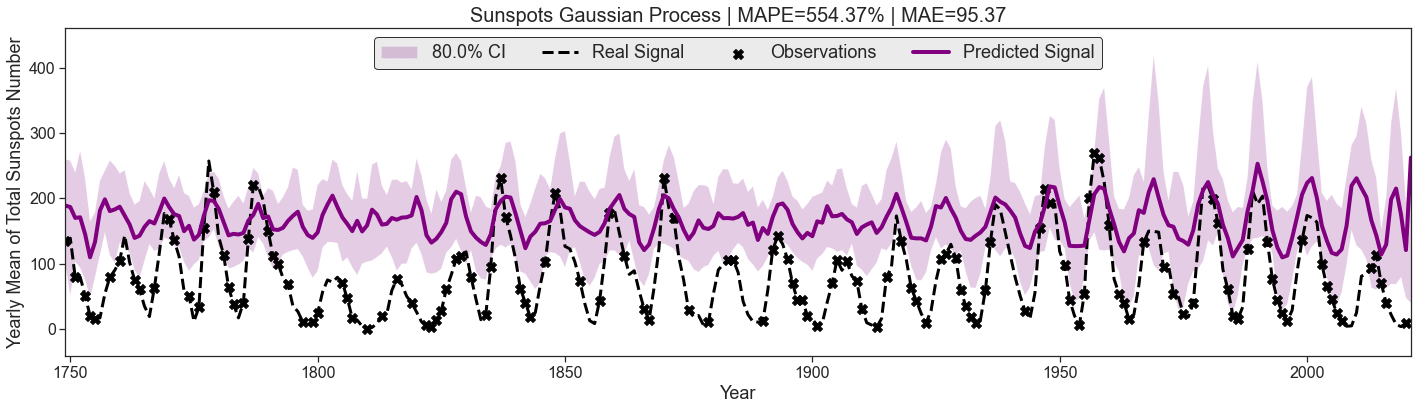

In [160]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number', nsamples = 10,  valid_index = valid_index,
                 pred_kwargs={'c':'purple', 'lw':4, 'label':'Predicted Signal', 'alpha':1.0},
                 CI_kwargs={'facecolor':'purple', 'alpha':0.2, 'ls':'--'})


## Modelo Kernel SIN

In [151]:
def model(df, index_obs, dim = 100): 
    inputs = ['Year']
    outputs = ["Yearly Mean Total Sunspot Number"]
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)
    
    var_sin = tg.TgPrior('var_sin', ['Year'], dim=dim, low=0, high=1, alpha=2, beta=4)
    relevance = tg.TgPrior('relevance', ['Year'], dim=dim, low=0.0, high=2, alpha=2, beta=4) #low = 0.0, high = 2
    period = tg.TgPrior('period', ['Year'], dim=dim, low=0.02, high=1, alpha=2, beta=4) #low = 1, high = 5 
    shift = tg.TgPrior('shift', ['Year'], dim=dim, low=-0.01, high=0, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Year'], dim=dim, low=0, high=1.2, alpha=2, beta=4)
    
    kernel = tg.SIN(var_sin, relevance, period)
    cov = tg.CovarianceTransport(kernel)    

    marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift) )
    positive = tg.MarginalTransport(tg.Relu())

    tgp = tg.TGP([cov, marginal, positive], dt=dt)
    tgp.obs(index_obs)
    return tgp

### No entrenado

In [152]:
tgp = model(sunspotsAnual, train_index)

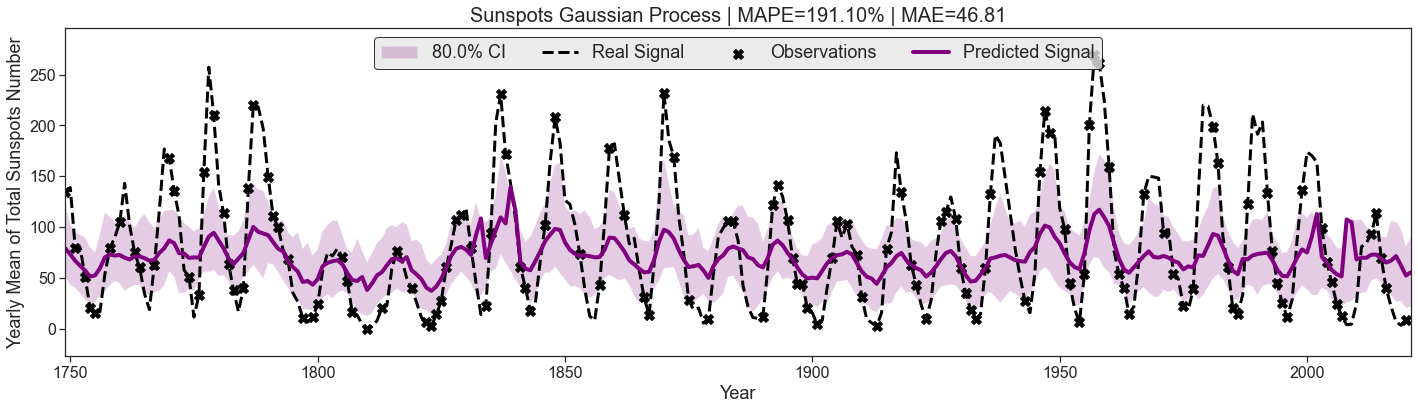

In [153]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number', nsamples = 10,  valid_index = valid_index,
                 pred_kwargs={'c':'purple', 'lw':4, 'label':'Predicted Signal', 'alpha':1.0},
                 CI_kwargs={'facecolor':'purple', 'alpha':0.2, 'ls':'--'})

### Entrenado  

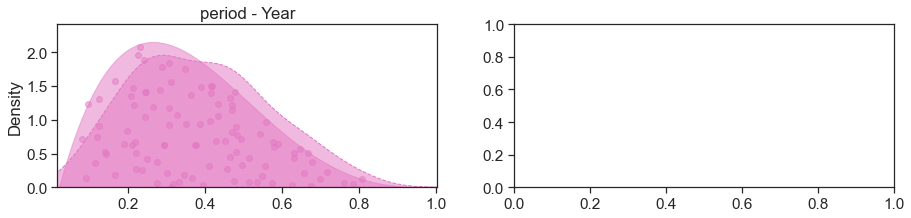

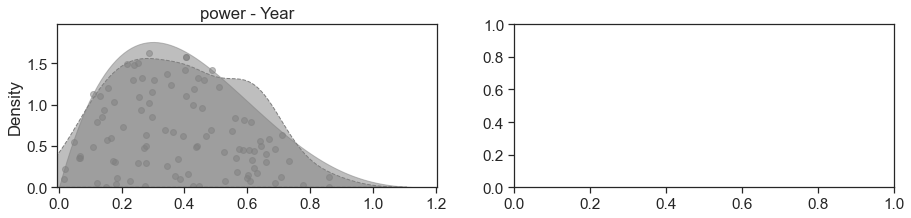

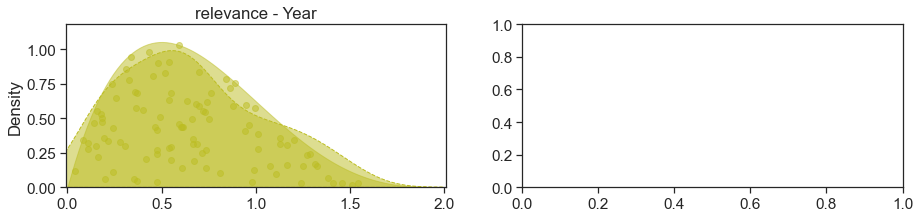

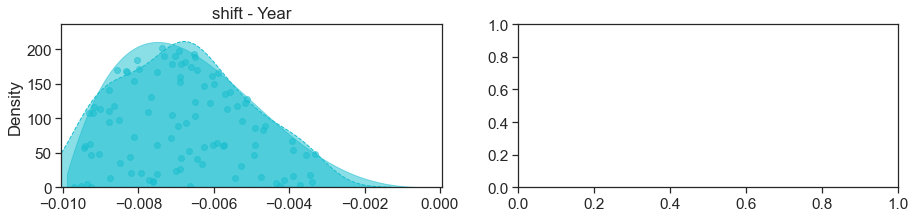

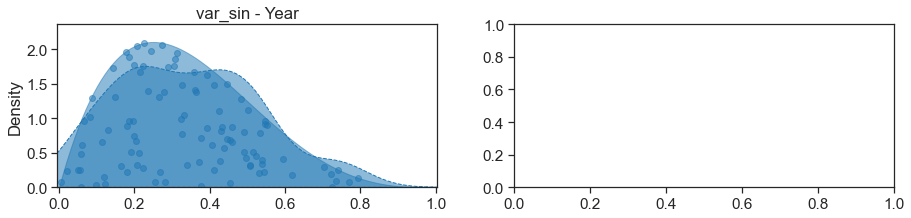

  0%|                                                                                                         …

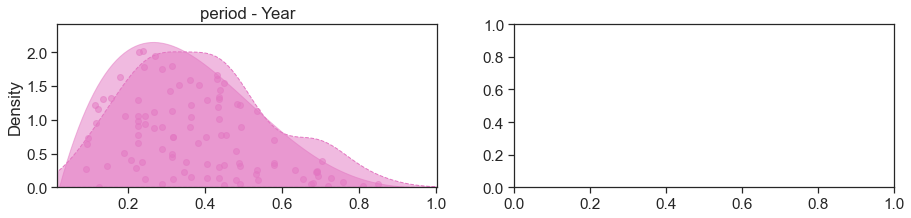

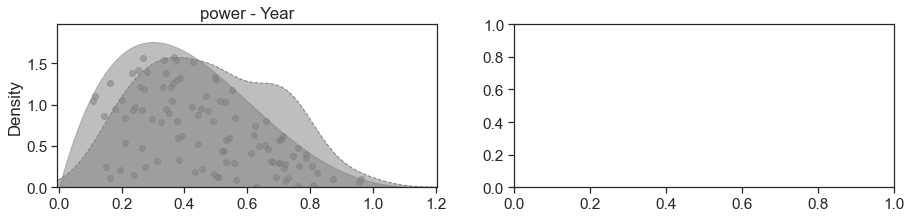

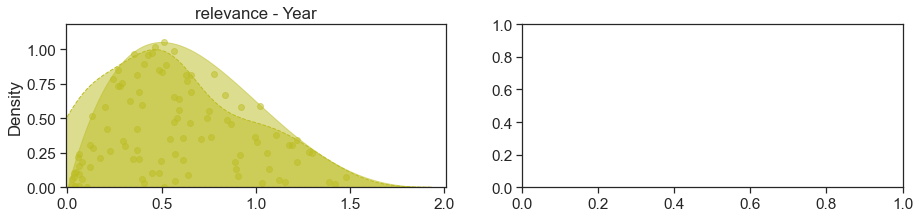

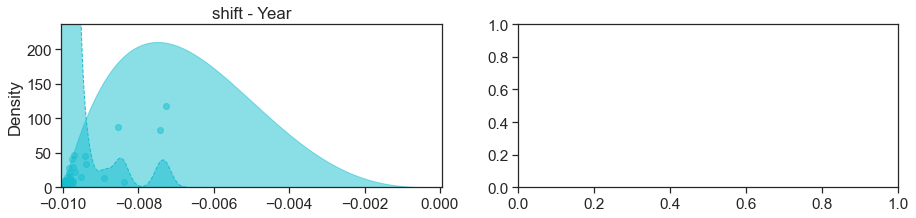

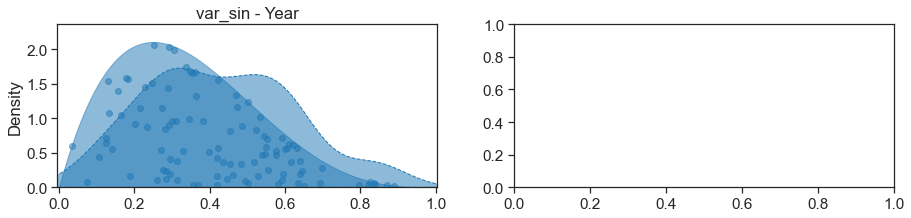

In [154]:
train(tgp)

### Gráfico

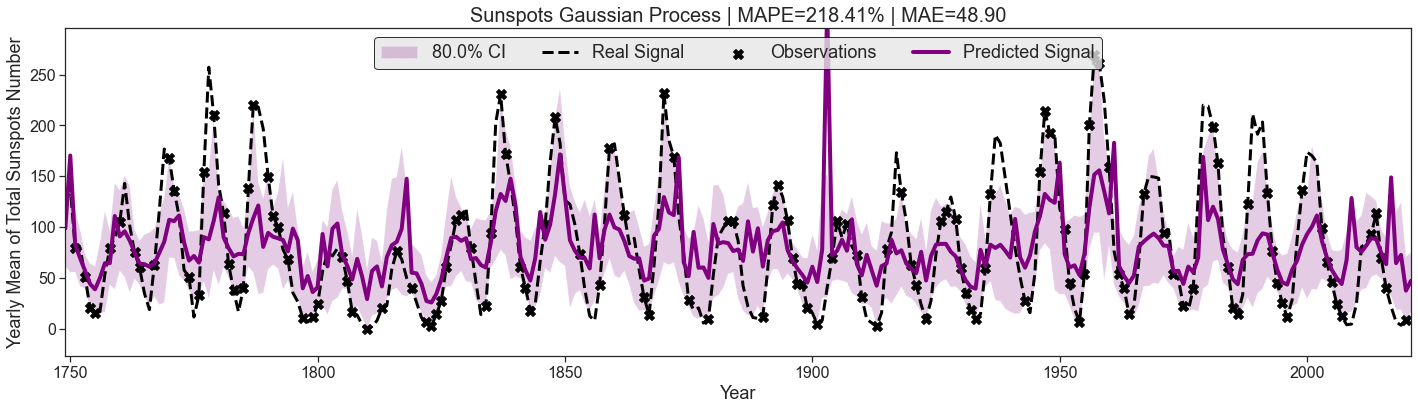

In [155]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number', nsamples = 10,  valid_index = valid_index,
                 pred_kwargs={'c':'purple', 'lw':4, 'label':'Predicted Signal', 'alpha':1.0},
                 CI_kwargs={'facecolor':'purple', 'alpha':0.2, 'ls':'--'})

## Modelo Kernel SM

In [146]:
def model(df, index_obs, dim = 100): 
    inputs = ['Year']
    outputs = ["Yearly Mean Total Sunspot Number"]
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)
    
    var_sm = tg.TgPrior('var_rq', ['Year'], dim=dim, low=0, high=1, alpha=2, beta=4)
    relevance = tg.TgPrior('relevance', ['Year'], dim=dim, low=0.0, high=2, alpha=2, beta=4) #low = 0.0, high = 2
    period = tg.TgPrior('period', ['Year'], dim=dim, low=0.02, high=1, alpha=2, beta=4) #low = 1, high = 5 
    shift = tg.TgPrior('shift', ['Year'], dim=dim, low=-0.01, high=0, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Year'], dim=dim, low=0, high=1.2, alpha=2, beta=4)

    kernel = tg.SIN(var_sm, relevance, period)
    cov = tg.CovarianceTransport(kernel)    

    marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift) )
    positive = tg.MarginalTransport(tg.Relu())

    tgp = tg.TGP([cov, marginal, positive], dt=dt)
    tgp.obs(index_obs)
    return tgp

### No entrenado

In [147]:
tgp = model(sunspotsAnual, train_index)

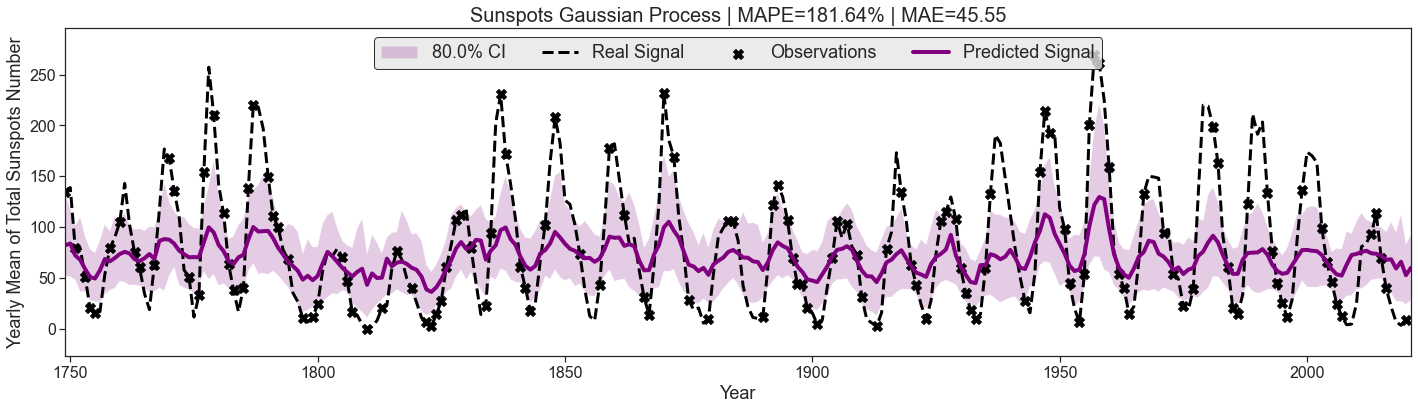

In [148]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number', nsamples = 10,  valid_index = valid_index,
                 pred_kwargs={'c':'purple', 'lw':4, 'label':'Predicted Signal', 'alpha':1.0},
                 CI_kwargs={'facecolor':'purple', 'alpha':0.2, 'ls':'--'})

### Entrenado

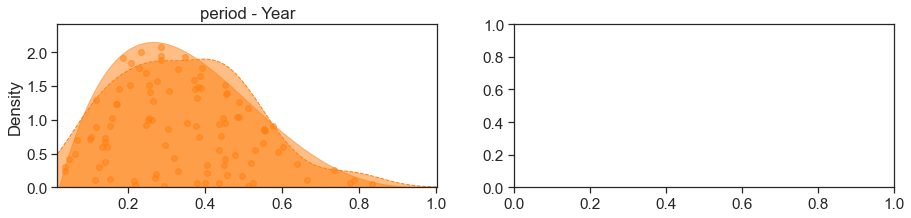

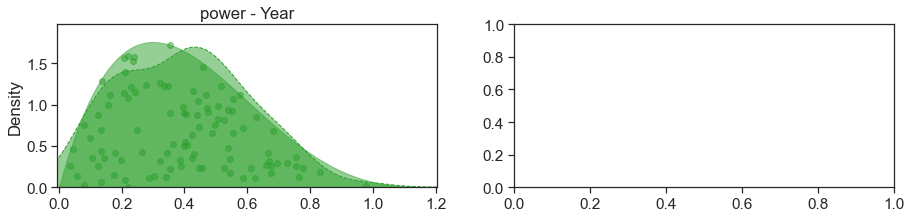

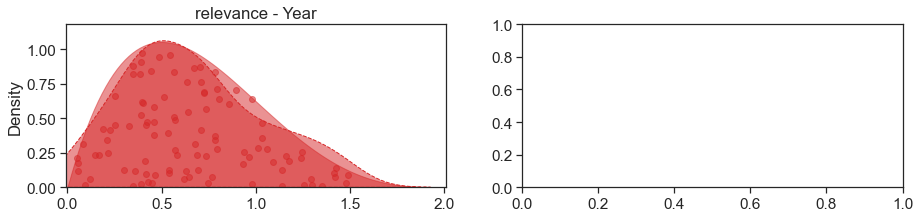

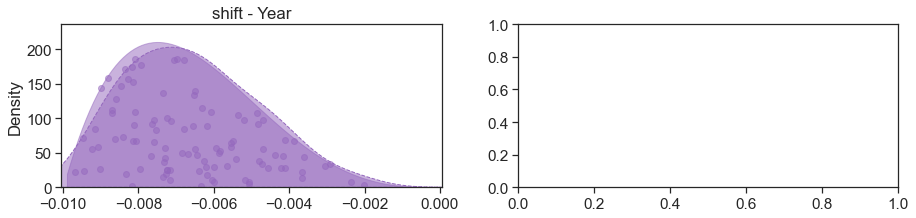

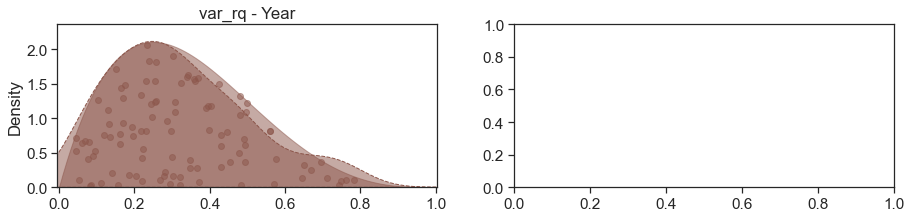

  0%|                                                                                                         …

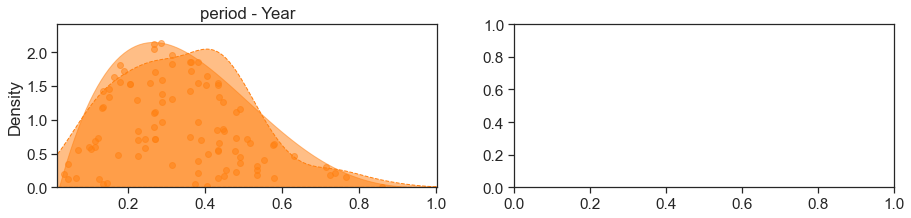

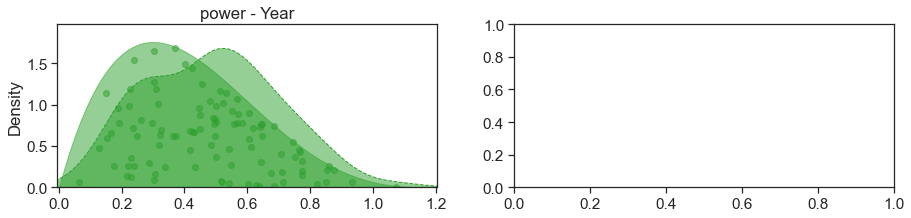

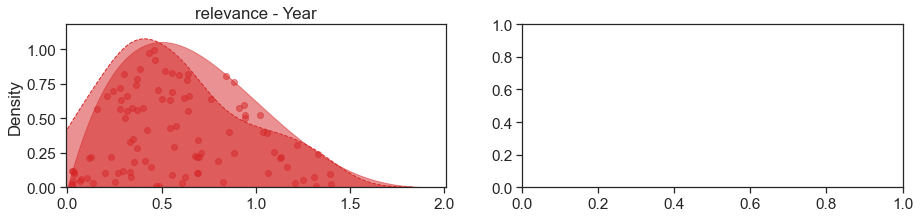

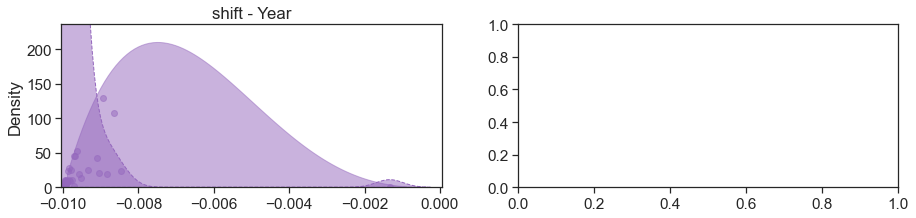

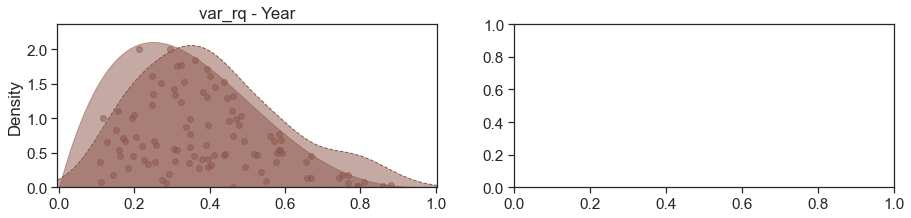

In [149]:
train(tgp)

### Gráfico

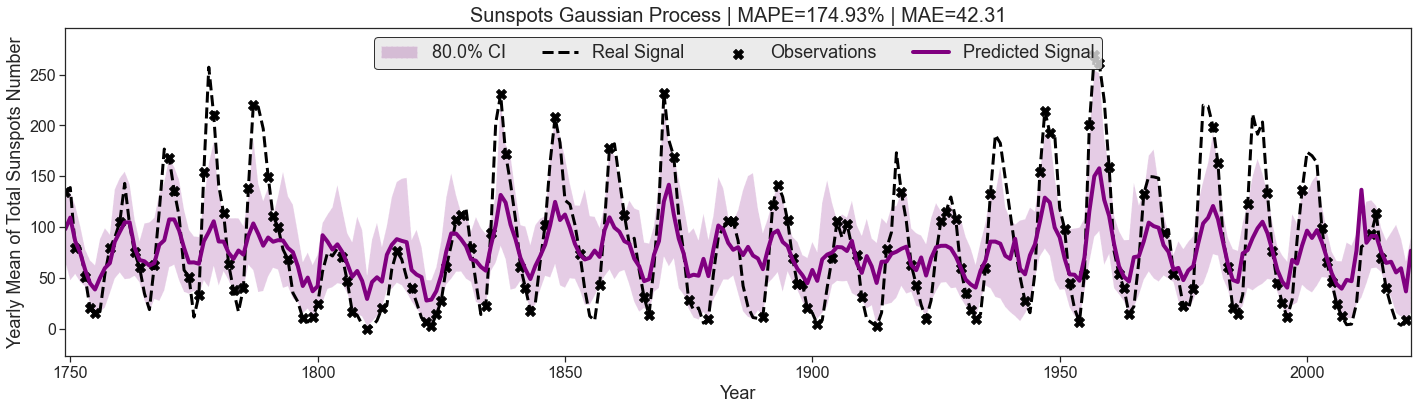

In [150]:
tgp.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number', nsamples = 10,  valid_index = valid_index,
                 pred_kwargs={'c':'purple', 'lw':4, 'label':'Predicted Signal', 'alpha':1.0},
                 CI_kwargs={'facecolor':'purple', 'alpha':0.2, 'ls':'--'})

## Tabla Resumen



Kernel|MAPE|MAE
-----|-----|----- 
Lineal|340.84%|67.39
Polinomial|268.97%|60.98
SE|97.15%|29.12
RQ|48.83%|17.34
SINC|554.37%|95.37
SIN|218.41%|48.90
SM|174.93%|42.31
